In [1]:
# initial setup
import sys
sys.path.append("../analysis")

In [2]:
import parsing
import extraction
import timing
import utils

In [3]:
from extraction import pull_spec_in, split_spec
from utils import fetch

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
multiplies_raw = fetch("2020-04-30-all-experiments-timings-for-further-eval")
loads_raw = fetch("2020-04-30-all-experiments-timings-for-further-eval-loads-only")
stats_raw = fetch("2020-04-30-all-experiments-timings-for-further-eval-stats")
swinv_times = utils.fetch_swizzle_inventor(
    "2020-05-04-swizzle-inventor-benchmarks-fixed-script")

In [7]:
swinv_times

,spec,time
0,l1/1d-conv,9.073
1,l1/1d-stencil,6.753
2,l1/2d-stencil-3,21.160
3,l1/2d-stencil-5,65.945
4,l1/trove-crc-1,0.123
5,l1/trove-crc-2,0.342
6,l1/trove-crc-3,1.078
7,l1/trove-crc-4,0.782
8,l1/trove-crc-5,2.138
9,l1/trove-crc-7,11.062


Having loaded the data, I'll make a more expanded breakdown of the time it takes to execute Swizzleflow on various benchmarks.

I'll take the time it took to build and multiply all the matrices from the benchmark suite that ran with an empty cache, the time it took to load the cached aatrix from my rerun (which had a fully populated matrix cache), and then one of the search times.

We'll also add in the Swizzle Inventor times.

In [8]:
multiply_times = timing.process(multiplies_raw)
load_only_times = timing.process(loads_raw)

Before we continue, let's make sure that the two search runs weren't significantly different so we can feel comfortable picking either one

In [9]:
search_variations = multiply_times['search time'] - load_only_times['search time']
search_variations.head()

spec
l3/trove-rcr-5    -0.000100
l3/trove-crc-5     0.000092
l3/2d-stencil-5    0.001524
l1/trove-rcr-5     0.001773
l1/trove-crc-5     0.005072
Name: search time, dtype: float64

In [10]:
search_variations.mean()

-0.0008868292888888906

In [11]:
search_variations.std()

0.009914124536938228

In [12]:
(search_variations ** 2).sum() / len(search_variations)

9.689211229190912e-05

With that bit of preemptive analysis done, I can conclude that there weren't any meaningful random fluctuations in the data between our two Swizzleflow benchmark runs that didn't collect detailed statistics.

In [13]:
swinv_times_for_join = swinv_times.set_index('spec')\
    .rename({'time': 'swizzle inventor'}, axis=1)
for p in ['l3/trove-rcr-3', 'l3/trove-rcr-5']:
    swinv_times_for_join.loc[p] = [np.nan]

In [14]:
timings =\
(load_only_times.rename({"matrix time": "load time"}, axis=1)\
    .join(multiply_times, how='inner',
         rsuffix=" r")[["matrix time", "load time", "search time"]])\
    .join(swinv_times_for_join, how="inner", sort=True)
timings.head()

,matrix time,load time,search time,swizzle inventor
spec,,,,
l1/1d-conv,0.018468,0.018549,0.013639,9.073
l1/1d-stencil,3.335432,0.018640,0.006689,6.753
l1/2d-stencil-3,1.539753,0.019292,0.004844,21.160
l1/2d-stencil-5,1897.150403,0.173086,0.055123,65.945
l1/trove-crc-1,0.021668,0.001503,0.000322,0.123


In [15]:
timings = extraction.split_spec(timings.reset_index()).drop('spec', axis=1)

In [16]:
for_plot = timings.copy()
for_plot['problem'] = for_plot['problem'].map(utils.PROBLEM_NAMES)
for_plot['level'] = for_plot['level'].map({1: 'R', 2: 'FC', 3: 'F'})

In [17]:
for_plot.rename({'problem': 'Problem', 'matrix time': 'Mat. creation',
                'load time': 'Mat. load', 'search time': 'Search',
                'swizzle inventor': 'Swizzle Inventor', 'level': 'Level'},
                axis=1, inplace=True)

In [18]:
max_mat_time = for_plot[['Mat. creation', 'Mat. load']].max(axis=1)
for_plot['Total'] = max_mat_time + for_plot['Search']

In [19]:
groups_len = len(for_plot.groupby('Problem'))
groups_len

12

In [20]:
plot_cols = 3

In the plot below, we compare synthesis times for several benchmarks under the two (or three, if there are conditionals in the sketch) synthesis grammers used by Swizzle Inventor.

We have

- The Restricted grammar (R), or Level 1, where the swizzles have to grouping or wrapping, and conditionals cannot add or subtract a constant
- The Full Conditionals grammer (FC), or Level 2, which is like the Restricted grammar except that conditinoals can now add constants from as mall family of values ($[0, \pm 1, \pm N]$)
- The Full grammar (F), or Level 3, which enables grouping, wrapping, and other such operations in the swizzle template. Swizzleflow doesn't show much of a performance penalty when using this grammer, while Swizzle Inventor does

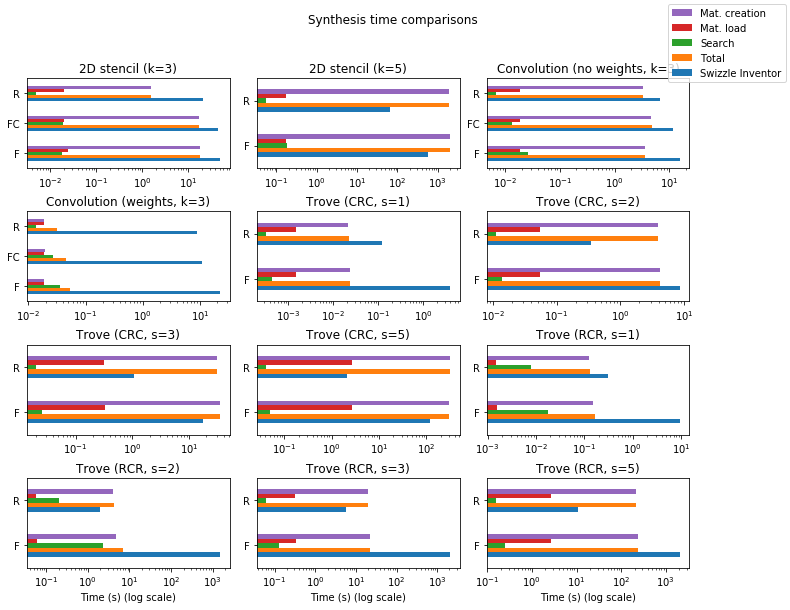

In [21]:
fig, axs = plt.subplots((groups_len + plot_cols - 1) // plot_cols, plot_cols,
                       figsize=(11, 8.5))
for idx, group in enumerate(for_plot.groupby('Problem')):
    name, df = group
    ax = axs[idx // plot_cols][idx % plot_cols]
    df = df.set_index('Level')
    # Fix the order of the level groups, remove if it somehow reverses again
    if 'FC' in df.index:
        df = df.reindex(['F', 'FC', 'R'])
    else:
        df = df.reindex(['F', 'R'])
    df = df.fillna(35 * 60) # Plot timeouts somehow
    # The order of the bars in backwards from how I'd like it, fix that
    df = df[["Mat. creation", "Mat. load", "Search",
             "Total", "Swizzle Inventor"][::-1]]
    df.plot(kind='barh', ax=ax, legend=False, logx=True)
    ax.set_ylabel('')
    #ax.set_xlabel("Time (s), log scale")
    ax.set_title(name)
for ax in axs[-1]:
    ax.set_xlabel("Time (s) (log scale)")
handles, labels = axs[-1][-1].get_legend_handles_labels()
handles.reverse()
labels.reverse()
fig.suptitle("Synthesis time comparisons")
fig.legend(handles, labels, loc='upper right')
fig.tight_layout()
# Magic formula for providing space for the legend
fig.subplots_adjust(top=0.875, right=0.875)

In [22]:
fig.savefig('/tmp/log-synthesis-times.pdf')

And now one that isn't log scale to show why we needed that

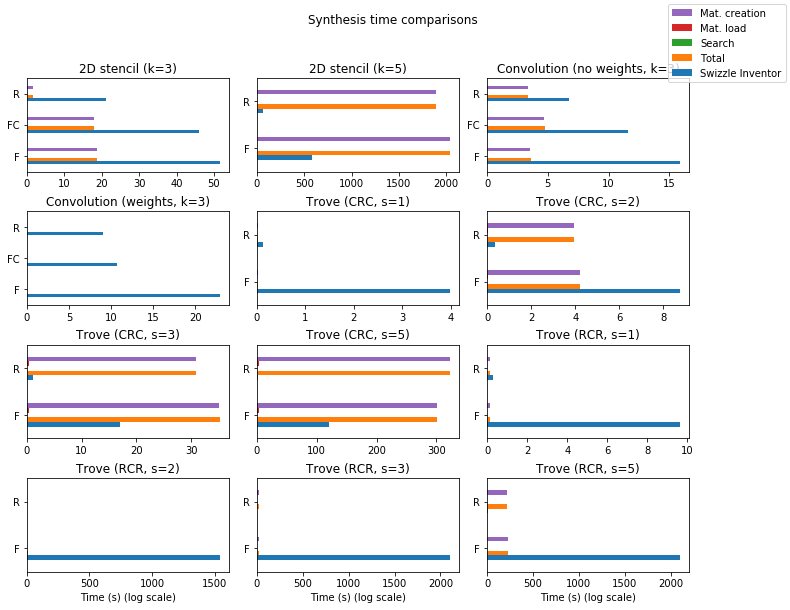

In [23]:
fig, axs = plt.subplots((groups_len + plot_cols - 1) // plot_cols, plot_cols,
                       figsize=(11, 8.5))
for idx, group in enumerate(for_plot.groupby('Problem')):
    name, df = group
    ax = axs[idx // plot_cols][idx % plot_cols]
    df = df.set_index('Level')
    # Fix the order of the level groups, remove if it somehow reverses again
    if 'FC' in df.index:
        df = df.reindex(['F', 'FC', 'R'])
    else:
        df = df.reindex(['F', 'R'])
    df = df.fillna(35 * 60) # Plot timeouts somehow
    # The order of the bars in backwards from how I'd like it, fix that
    df = df[["Mat. creation", "Mat. load", "Search",
             "Total", "Swizzle Inventor"][::-1]]
    df.plot(kind='barh', ax=ax, legend=False)
    ax.set_ylabel('')
    #ax.set_xlabel("Time (s), log scale")
    ax.set_title(name)
for ax in axs[-1]:
    ax.set_xlabel("Time (s) (log scale)")
handles, labels = axs[-1][-1].get_legend_handles_labels()
handles.reverse()
labels.reverse()
fig.suptitle("Synthesis time comparisons")
fig.legend(handles, labels, loc='upper right')
fig.tight_layout()
# Magic formula for providing space for the legend
fig.subplots_adjust(top=0.875, right=0.875)

In [24]:
fig.savefig('/tmp/synthesis-times.pdf')

## Getting a handle on our matrix multiplications

At this ponit, we'd like to get a sense on how matrix multiply timings (which dominate our search) are related to sapects of the problem. There's a few quick plots I can whip up.

In [25]:
matrix_info_frame = pull_spec_in(extraction.matrix_stats(stats_raw))

In [26]:
multiply_stats = matrix_info_frame[matrix_info_frame["category"] == "mul"].copy()
multiply_stats.drop("category", axis=1, inplace=True)

In [27]:
# Let's do that quick check on whether the stat collection affected times
stats_variations = timing.process(stats_raw)['matrix time']\
    - multiply_times['matrix time']
stats_variations

spec
l3/trove-rcr-5       91.963494
l3/trove-crc-5       50.665804
l3/2d-stencil-5      95.647482
l1/trove-rcr-5       86.513747
l1/trove-crc-5       45.348946
l1/2d-stencil-5      80.692389
l2/1d-stencil         0.997190
l2/2d-stencil-3       3.210895
l2/1d-conv           -0.000927
l2/mult-32-with-4     0.001746
l3/trove-crc-3       11.218566
l3/trove-crc-1        0.011647
l3/trove-crc-4       21.343343
l3/1d-stencil         0.927098
l3/2d-stencil-3       3.183114
l3/trove-rcr-3        9.125789
l3/trove-cr_sum-3     0.943758
l3/trove-rcr-1        0.058869
l3/1d-conv           -0.000183
l3/trove-rcr-4       41.580318
l3/trove-cr_sum-1    -0.000250
l3/mult-32-with-4     0.000697
l3/trove-cr_sum-4     1.687039
l3/trove-rcr-2        1.374423
l3/trove-cr_sum-2     0.328950
l3/trove-cr_sum-5     3.931508
l3/trove-crc-2        1.650597
l1/trove-crc-3       10.874834
l1/trove-crc-1        0.010122
l1/trove-crc-4       40.651299
l1/trove-cr_sum-7    13.830408
l1/1d-stencil         0.893351
l1/

From the above, it's clear that the process of getting more detailed information about our multiplication has a speed penalty in a lot of cases, so we'll need to use the timings from the stats-free set of benchmarks

In [28]:
low_stat_records = pull_spec_in(extraction.matrix_stats(multiplies_raw))
low_stat_records = low_stat_records[low_stat_records["category"] == "mul"]
stats_times =\
    multiply_stats.drop("time", axis=1).set_index("key")\
    .join(low_stat_records[["key", "time"]].set_index("key"),
            on="key", how='inner')
assert(len(stats_times) == len(multiply_stats))
stats_times.head()

,n_ones,n_elems,in_slots,out_slots,density,spec,time
key,,,,,,,
"matrices/32,5-col_rots_32,5-col_xforms-32,5",24592394,655360000,160,160,0.037525,l3/trove-rcr-5,97.633074
"matrices/32,5-col_rots_32,5-col_xforms_32,5-row_rots-32,5",122961970,655360000,160,160,0.187625,l3/trove-rcr-5,40.627363
"matrices/32,5-col_rots_32,5-col_xforms_32,5-row_rots_32,5-row_xforms-32,5",606086220,655360000,160,160,0.924814,l3/trove-rcr-5,44.172051
"matrices/32,5-col_rots_32,5-col_xforms_32,5-row_rots_32,5-row_xforms_32,5-col_rots-32,5",631057500,655360000,160,160,0.962917,l3/trove-rcr-5,42.149255
"matrices/32,5-row_rots_32,5-row_xforms-32,5",627000,655360000,160,160,0.000957,l3/trove-crc-5,18.513864


Now that we have the times, let's eyeball some hypotheses.

Hypothesis 1: The number of 1s in a matrix is correlated with multiplication time

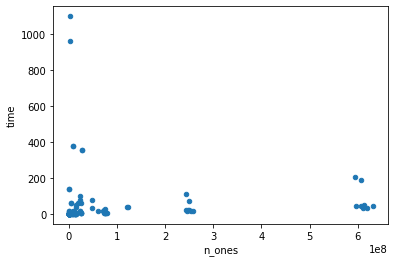

In [29]:
stats_times.plot(x='n_ones', y='time', kind='scatter')

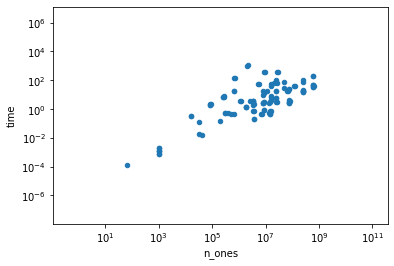

In [30]:
stats_times.plot(x='n_ones', y='time', kind='scatter', logx=True, logy=True)

Eyeball says there might be sometheng there, but you have to go to log-log plots to see it. This could also be the case that bigger matrices have more 1s in them and thes need more time no matter what.

Hyothesis 2: Multiplication time has some relationship to 

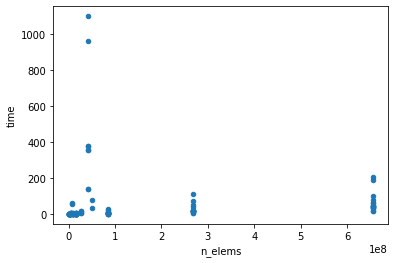

In [31]:
stats_times.plot(kind='scatter', x='n_elems', y='time')

**TODO** Matrix multiply time is a function of properties (the density, etc) of the _input_, and we currently only have info for the _output_ matrix. We can reconstruct the input info because we have all the relevant rows (as either `build`s or `loads`s), but getting that working is not a 1 AM sort of thing.

So I'm going to leave myself this note and add a reminded to the weekly agenda so that this happens afther the talk.